In [4]:
from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import sem
from scipy.stats import t

data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=True)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=True)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=True)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=True)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=True)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=True)

In [6]:
rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

In [9]:
min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

85.96888773680799

In [19]:
time = np.linspace(1969,2023,648)

rain_flat = rain.reshape(rain.shape[0], -1)  # Flatten all grid cells for each time step
hurs_flat = hurs.reshape(hurs.shape[0], -1)
temp_flat = temp.reshape(temp.shape[0], -1)
temp_max_flat = temp_max.reshape(temp_max.shape[0], -1)
temp_min_flat = temp_min.reshape(temp_min.shape[0], -1)
sun_flat = sun.reshape(sun.shape[0], -1)
frost_flat = frost.reshape(frost.shape[0], -1)
wind_flat = wind.reshape(wind.shape[0], -1)
psl_flat = psl.reshape(psl.shape[0], -1)


In [20]:
psl_flat.shape

(648, 9184)

In [25]:
# Create a DataFrame excluding 'Time'
df = pd.DataFrame({
    'Rain': rain_flat.flatten(),
    'Hurs': hurs_flat.flatten(),
    'Temp': temp_flat.flatten(),
    'Temp_Max': temp_max_flat.flatten(),
    'Temp_Min': temp_min_flat.flatten(),
    'Sun': sun_flat.flatten(),
    'Frost': frost_flat.flatten(),
    'Wind': wind_flat.flatten(),
    'Psl': psl_flat.flatten(),
})

# Lagged features
lags = 12  # Adjust based on the expected temporal patterns
for i in range(1, lags + 1):
    df[f'Temp_Lag_{i}'] = df['Temp'].shift(i)
    df[f'Rain_Lag_{i}'] = df['Rain'].shift(i)
    # Add columns for lagged features of other variables

# Drop rows with NaN values introduced by lagging
df = df.dropna()

# Target variable (future temperatures over the entire grid)
y = df['Temp'].values

# Features
X = df.drop(['Temp'], axis=1).values

# Display the DataFrame (optional)
print(df.head())


           Rain       Hurs      Temp  Temp_Max  Temp_Min        Sun  \
1442  97.199969  88.014670  5.945635  8.564135  3.301113  66.901918   
1443  92.625634  87.776992  6.107175  8.661650  3.525804  70.113541   
1444  83.085132  87.342205  6.352391  9.060527  3.666079  74.088605   
1445  77.290103  86.387695  6.428609  9.241482  3.715758  76.631510   
1446  74.336589  86.147593  6.371309  9.299901  3.533701  76.078219   

          Frost      Wind          Psl  Temp_Lag_1  ...  Temp_Lag_8  \
1442  19.302313  5.956586  1011.774673    5.994779  ...    6.831285   
1443  19.192417  5.677099  1011.814594    5.945635  ...    6.857659   
1444  18.791416  4.959681  1011.873417    6.107175  ...    6.841226   
1445  18.091832  4.990169  1011.947486    6.352391  ...    6.805163   
1446  18.888496  4.767054  1012.014692    6.428609  ...    6.297439   

      Rain_Lag_8  Temp_Lag_9  Rain_Lag_9  Temp_Lag_10  Rain_Lag_10  \
1442   86.783093    6.911683   93.547495     6.892563   102.284484   
1443  

Mean Squared Error: 0.005158640457323163


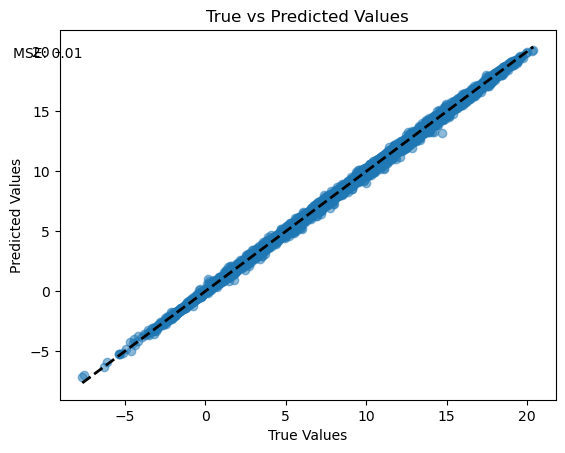

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model (for example, using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


import matplotlib.pyplot as plt

# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line for reference
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', linewidth=2)

# Display the MSE score on the plot
plt.text(min(y_test), max(y_test), f'MSE: {mse:.2f}', verticalalignment='top', horizontalalignment='right')

# Show the plot
plt.show()


In [28]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print the R-squared value
print(f"R-squared: {r2}")


R-squared: 0.9997740293258556


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Assuming df is your original DataFrame with historical data
# Ensure that df has lagged features for the historical period

# 1. Prepare Future Features
future_start_index = df.index.max() + 1
future_end_index = future_start_index + 35  # Example: Predicting for 36 periods

# Create future DataFrame with the same lagged features
future_df = pd.DataFrame(index=range(future_start_index, future_end_index + 1))
for lag in range(1, 13):  # Assuming you have lagged features up to lag 12
    future_df[f'Temp_Lag_{lag}'] = df['Temp'].shift(lag)

# Include additional features from the historical data
additional_features = ['Frost', 'Hurs', 'Psl', 'Rain', 'Sun', 'Wind']
for feature in additional_features:
    future_df[feature] = df[feature].iloc[-1]  # Use the last available values

# Use the last available values in the historical data for the first row of future_df
last_available_values = df.iloc[-1][[f'Temp_Lag_{lag}' for lag in range(1, 13)]].values
future_df.iloc[0, :12] = last_available_values  # Assign values to the first 12 columns

# Initialize a new KNNImputer for future features
future_imputer = KNNImputer(n_neighbors=5)  # Adjust the number of neighbors as needed

# Impute missing values in future features using the new imputer
imputed_future_df = future_imputer.fit_transform(future_df)

# Extract features for prediction
future_features = imputed_future_df[:, :-1]  # Exclude the last column (target variable)

# 2. Use the Trained Model
# Assume rf_model is your trained Random Forest model
if not future_df.empty:
    future_predictions = rf_model.predict(future_features)

    # 3. Visualize Predictions
    plt.plot(df.index, df['Temp'], label='Historical Data')
    plt.plot(future_df.index, future_predictions, label='Future Predictions', linestyle='dashed')
    plt.title('Historical and Future Temperature Predictions')
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()
else:
    print("No valid samples for future prediction.")


ValueError: X has 17 features, but RandomForestRegressor is expecting 32 features as input.